In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import pickle

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
)
from monai.utils import set_determinism
from tqdm import tqdm

import torch

from utils.transforms import tumor_seg_transform as data_transform

# print_config()

In [2]:
RANDOM_SEED = 0
ROOT_DIR = "/scratch1/sachinsa/brats_seg"
DATA_ROOT_DIR = "/scratch1/sachinsa/data"

In [3]:
from utils.logger import Logger
logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [4]:
set_determinism(seed=RANDOM_SEED)

In [5]:
train_transform = data_transform['train']
val_transform = data_transform['val']

In [6]:
from torch.utils.data import Subset

# here we don't cache any data in case out of memory issue
train_dataset = DecathlonDataset(
    root_dir=DATA_ROOT_DIR,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=8,#4,
)
val_dataset = DecathlonDataset(
    root_dir=DATA_ROOT_DIR,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=8,#4,
)

logger.debug("Data loaded")
logger.debug(f"Length of dataset: {len(train_dataset)}, {len(val_dataset)}")

2024-11-27 13:06:41,701 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-11-27 13:06:41,703 - INFO - File exists: /scratch1/sachinsa/data/Task01_BrainTumour.tar, skipped downloading.
2024-11-27 13:06:41,704 - INFO - Non-empty folder exists in /scratch1/sachinsa/data/Task01_BrainTumour, skipped extracting.
[DEBUG] Data loaded
[DEBUG] Length of dataset: 388, 96
[DEBUG] Batch-size: 2, 2
[DEBUG] Length of data-loaders: 194, 48


In [13]:
ids_ = train_dataset.get_indices()
ids_.sort()
print(ids_)

[  0   2   3   4   5   9  11  13  14  16  17  18  19  20  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  55  57  58  59  61  62  63  64  65
  66  67  68  69  70  72  73  74  77  79  80  81  82  83  84  85  86  87
  88  89  91  92  93  94  95  97  98  99 101 103 104 105 106 108 109 110
 111 112 114 115 116 117 119 120 121 122 123 125 126 127 128 129 130 131
 133 135 136 137 138 139 140 143 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 165 166 167 168 169 171 172 173 174
 175 176 177 178 180 181 182 183 184 185 187 189 190 192 193 195 197 198
 199 200 201 202 203 204 206 207 208 209 210 211 212 213 214 215 216 217
 218 221 222 223 224 226 227 228 229 230 232 233 234 235 237 242 243 244
 247 248 249 251 252 253 254 255 256 257 258 259 260 261 262 264 265 266
 267 269 270 271 272 273 274 275 276 277 278 279 280 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 30

In [14]:
brain_slice = train_dataset[0]['image']
print(brain_slice.shape)

torch.Size([4, 64, 64, 64])


In [15]:
brain_slice = val_dataset[0]['image']
print(brain_slice.shape)

torch.Size([4, 240, 240, 155])


torch.Size([240, 240])


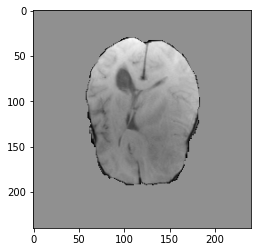

In [23]:
import numpy as np
id_ = 75
ids_ = val_dataset.get_indices()
this_data = val_dataset[np.where(ids_ == id_)[0][0]]
brain_slice = val_dataset[0]['image'][1][...,77].T
print(brain_slice.shape)
plt.imshow(brain_slice, cmap='gray')